# <center>Death prediction based on the VAERS post vaccine adverse reactions</center>

*<center>Szymon Szewczyk, Łukasz Szyszka</center>*

*<center>July 10, 2024</center>*

---

## Introduction

aaa

## Data Source

aaa

## Data Preprocessing

In [145]:
from cmdstanpy import CmdStanModel

import arviz as az
import numpy as np
import scipy.stats as stats
# import seaborn as sns

import matplotlib.pyplot as plt
import pandas as pd
# from .autonotebook import tqdm as notebook_tqdm

In [146]:
df_data = pd.read_csv("../dane/2022VAERSDATA.csv", encoding='latin1', low_memory=False)
df_vax = pd.read_csv("../dane/2022VAERSVAX.csv", encoding='latin1', low_memory=False)
df = pd.merge(df_data, df_vax, on='VAERS_ID')

df.columns

Index(['VAERS_ID', 'RECVDATE', 'STATE', 'AGE_YRS', 'CAGE_YR', 'CAGE_MO', 'SEX',
       'RPT_DATE', 'SYMPTOM_TEXT', 'DIED', 'DATEDIED', 'L_THREAT', 'ER_VISIT',
       'HOSPITAL', 'HOSPDAYS', 'X_STAY', 'DISABLE', 'RECOVD', 'VAX_DATE',
       'ONSET_DATE', 'NUMDAYS', 'LAB_DATA', 'V_ADMINBY', 'V_FUNDBY',
       'OTHER_MEDS', 'CUR_ILL', 'HISTORY', 'PRIOR_VAX', 'SPLTTYPE',
       'FORM_VERS', 'TODAYS_DATE', 'BIRTH_DEFECT', 'OFC_VISIT', 'ER_ED_VISIT',
       'ALLERGIES', 'VAX_TYPE', 'VAX_MANU', 'VAX_LOT', 'VAX_DOSE_SERIES',
       'VAX_ROUTE', 'VAX_SITE', 'VAX_NAME'],
      dtype='object')

In [147]:
df = df[['VAERS_ID', "STATE", "CAGE_YR", "SEX", "DIED", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "VAX_TYPE", "VAX_MANU"]]

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 283454 entries, 0 to 283453
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VAERS_ID  283454 non-null  int64  
 1   STATE     227998 non-null  object 
 2   CAGE_YR   214658 non-null  float64
 3   SEX       283454 non-null  object 
 4   DIED      8248 non-null    object 
 5   HOSPITAL  39676 non-null   object 
 6   HOSPDAYS  23257 non-null   float64
 7   NUMDAYS   228359 non-null  float64
 8   VAX_TYPE  283454 non-null  object 
 9   VAX_MANU  283454 non-null  object 
dtypes: float64(3), int64(1), object(6)
memory usage: 23.8+ MB


In [148]:
df = df[df["SEX"].isin(["F", "M"])]
df['SEX'] = df['SEX'].apply(lambda x: 1 if x == 'F' else 0)
df = df.dropna(subset=["STATE", "CAGE_YR", "NUMDAYS"])
df['DIED'] = df['DIED'].apply(lambda x: 1 if x == 'Y' else 0)
df['HOSPITAL'] = df['HOSPITAL'].apply(lambda x: 1 if x == 'Y' else 0)
df['HOSPDAYS'] = pd.to_numeric(df['HOSPDAYS'], errors='coerce').fillna(0)

df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 173665 entries, 208 to 283453
Data columns (total 10 columns):
 #   Column    Non-Null Count   Dtype  
---  ------    --------------   -----  
 0   VAERS_ID  173665 non-null  int64  
 1   STATE     173665 non-null  object 
 2   CAGE_YR   173665 non-null  float64
 3   SEX       173665 non-null  int64  
 4   DIED      173665 non-null  int64  
 5   HOSPITAL  173665 non-null  int64  
 6   HOSPDAYS  173665 non-null  float64
 7   NUMDAYS   173665 non-null  float64
 8   VAX_TYPE  173665 non-null  object 
 9   VAX_MANU  173665 non-null  object 
dtypes: float64(3), int64(4), object(3)
memory usage: 14.6+ MB


### Additional constrains

- States
- Age
- Vaccine type

In [149]:
######################### STATES #######################
df = df[df["STATE"] != 'SD']
# df = df[df["STATES"].isin(["TN", "WI", "CA"])]

state_counts = df['STATE'].value_counts()
states_to_keep = state_counts[state_counts >= 200].index
df = df[df['STATE'].isin(states_to_keep)]

######################### AGE ########################
df = df[df["CAGE_YR"] >= 55]
df = df[df["CAGE_YR"] <= 100]

#################### VACCINE TYPE ########################
df = df[df["VAX_TYPE"] == 'COVID19']

#################### VACCINE MANU ########################
print(df["VAX_MANU"].value_counts())
# df = df[df["VAX_MANU"] == "JANSSEN"]

#################### HOSPITAL ########################
# df = df[df["HOSPITAL"] == 1]

#################### HOSPDAYS ########################
# df = df[df["HOSPDAYS"] >= 1]

#################### NUMDAYS ########################
# df = df[df["NUMDAYS"] >= 1]
df = df[df["NUMDAYS"] <= 500]

MODERNA                 34292
PFIZER\BIONTECH         28192
JANSSEN                  2285
NOVAVAX                    77
UNKNOWN MANUFACTURER       64
Name: VAX_MANU, dtype: int64


In [150]:
df["DIED"].value_counts()

0    58699
1     3518
Name: DIED, dtype: int64

## Distribution of outcomes

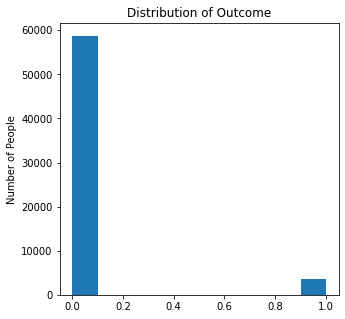

In [152]:
plt.figure(figsize=(5 , 5))
plt.hist(x=df["DIED"])
plt.ylabel('Number of People')
plt.title('Distribution of Outcome')
plt.show()

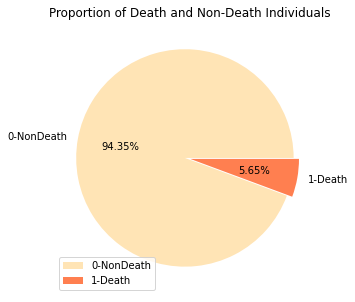

In [153]:
plt.figure(figsize=(5,5))
pie_data=df['DIED'].value_counts()
explode=(0.05,0)
colors=['moccasin','coral']
labels=['0-NonDeath','1-Death']
# sns.set(font_scale=1.5)
plt.pie(pie_data,labels=labels,autopct="%.2f%%",explode=explode,colors=colors)
plt.legend(labels, loc='lower left')
plt.title('Proportion of Death and Non-Death Individuals')
plt.show()

In [154]:
df.columns

Index(['VAERS_ID', 'STATE', 'CAGE_YR', 'SEX', 'DIED', 'HOSPITAL', 'HOSPDAYS',
       'NUMDAYS', 'VAX_TYPE', 'VAX_MANU'],
      dtype='object')

array([[<AxesSubplot:title={'center':'CAGE_YR'}>,
        <AxesSubplot:title={'center':'SEX'}>],
       [<AxesSubplot:title={'center':'HOSPITAL'}>,
        <AxesSubplot:title={'center':'HOSPDAYS'}>],
       [<AxesSubplot:title={'center':'NUMDAYS'}>,
        <AxesSubplot:title={'center':'DIED'}>]], dtype=object)

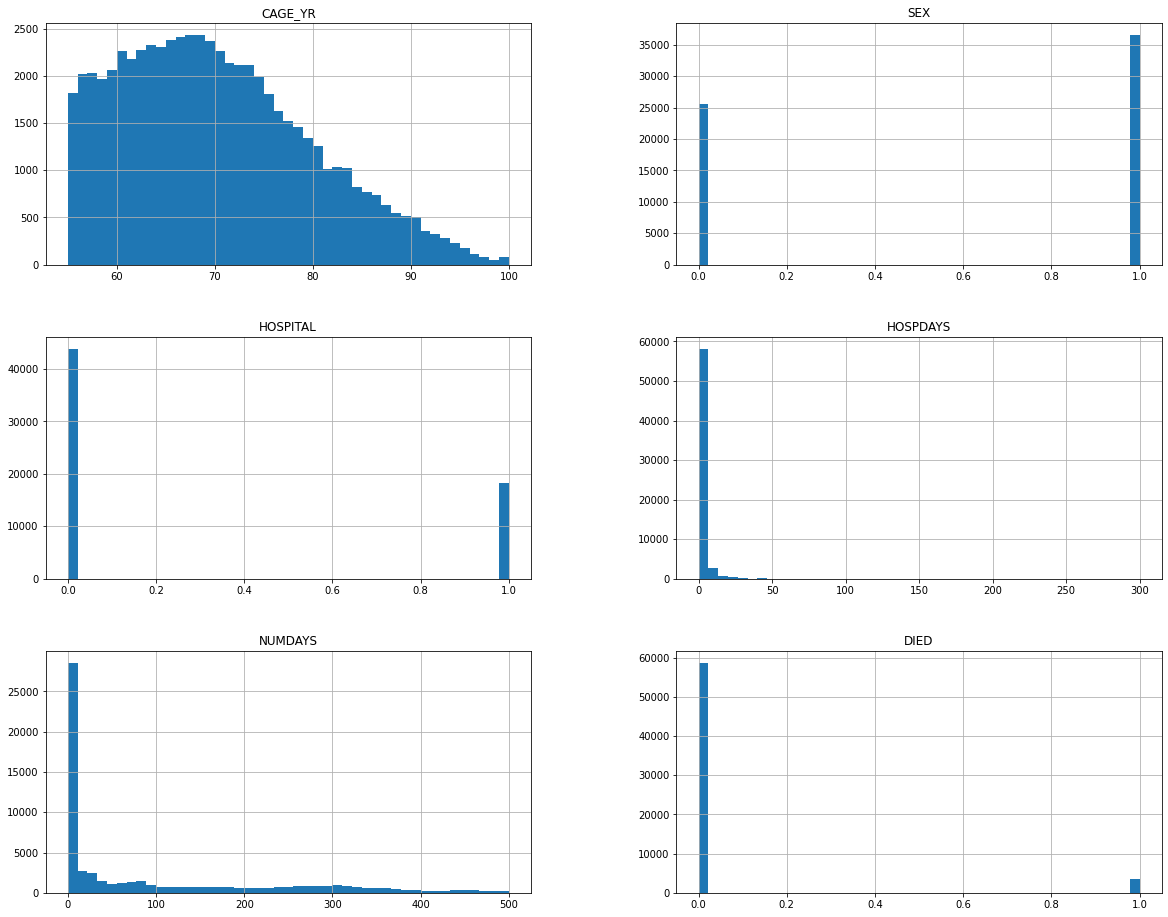

In [155]:
df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED", "STATE"]].hist(figsize=(20,16), grid=True, bins=45)

CAGE_YR        AxesSubplot(0.125,0.657941;0.227941x0.222059)
SEX         AxesSubplot(0.398529,0.657941;0.227941x0.222059)
HOSPITAL    AxesSubplot(0.672059,0.657941;0.227941x0.222059)
HOSPDAYS       AxesSubplot(0.125,0.391471;0.227941x0.222059)
NUMDAYS     AxesSubplot(0.398529,0.391471;0.227941x0.222059)
DIED        AxesSubplot(0.672059,0.391471;0.227941x0.222059)
dtype: object

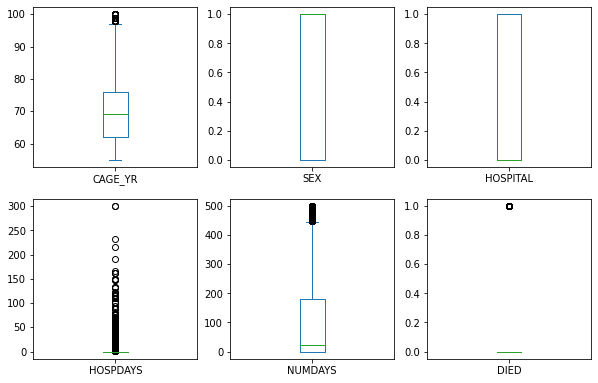

In [157]:
df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED", "STATE"]].plot(kind='box', subplots=True, layout=(3,3), sharex=False, sharey=False, figsize=(10,10))
# sns.set(font_scale = 1.5)

C:\Users\szyme\AppData\Local\Temp\ipykernel_39640\3813899854.py:3: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.CAGE_YR, ax = ax[0,0], color = 'orange')
C:\Users\szyme\AppData\Local\Temp\ipykernel_39640\3813899854.py:4: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(df.SEX, ax = ax[0,1], colo

<Axes: xlabel='DIED', ylabel='Density'>

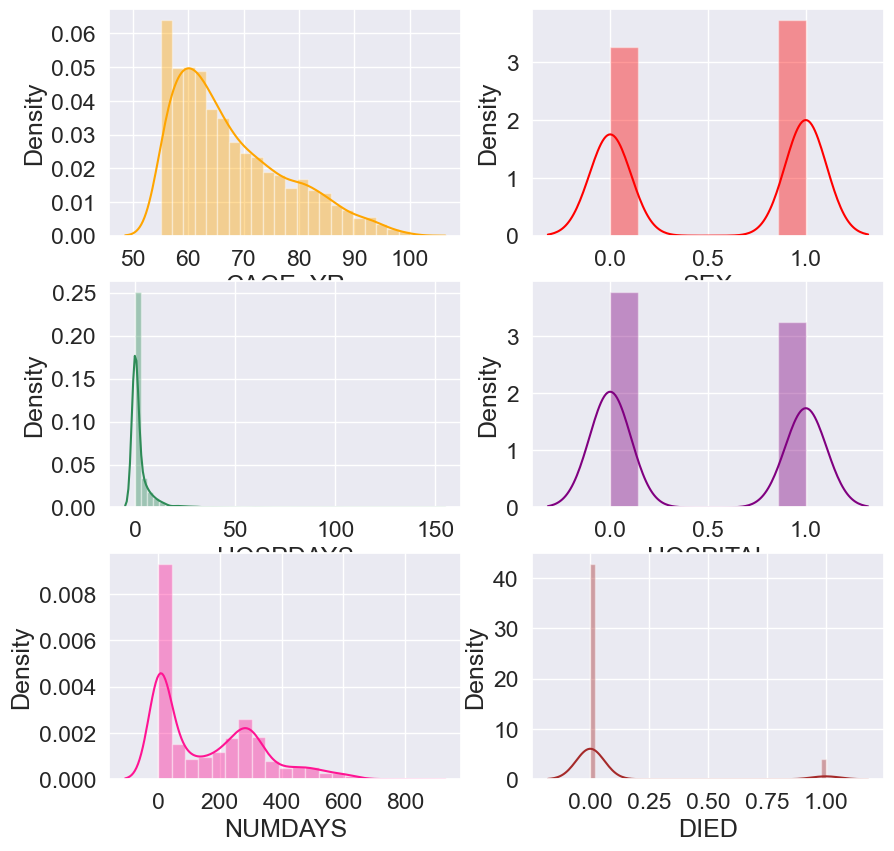

In [12]:
# fig, ax = plt.subplots(3,2, figsize=(10,10))
# sns.set(font_scale = 1)
# sns.distplot(df.CAGE_YR, ax = ax[0,0], color = 'orange')
# sns.distplot(df.SEX, ax = ax[0,1], color = 'red')
# sns.distplot(df.HOSPDAYS, ax = ax[1,0], color = 'seagreen')
# sns.distplot(df.HOSPITAL, ax = ax[1,1], color = 'purple')
# sns.distplot(df.NUMDAYS, ax = ax[2,0], color = 'deeppink')
# sns.distplot(df.DIED, ax = ax[2,1], color = 'brown')

In [166]:
corr = df[["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED"]].corr()
corr

,CAGE_YR,SEX,HOSPITAL,HOSPDAYS,NUMDAYS,DIED
CAGE_YR,1.000000,-0.058974,0.274458,0.085096,0.202875,0.158527
SEX,-0.058974,1.000000,-0.117110,-0.050528,-0.085120,-0.067373
HOSPITAL,0.274458,-0.117110,1.000000,0.387667,0.548910,0.145930
HOSPDAYS,0.085096,-0.050528,0.387667,1.000000,0.171013,0.173887
NUMDAYS,0.202875,-0.085120,0.548910,0.171013,1.000000,0.172551
DIED,0.158527,-0.067373,0.145930,0.173887,0.172551,1.000000


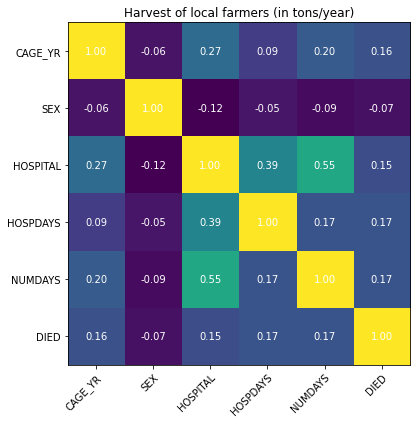

In [170]:
# plt.figure(figsize=(15,10))
# sns.set(font_scale = 1.5)
# sns.heatmap(corr, annot = True, cmap = 'plasma', vmin = -1, vmax = 1, linecolor='white', linewidths= 1)
cor = ["CAGE_YR", "SEX", "HOSPITAL", "HOSPDAYS", "NUMDAYS", "DIED"]

fig, ax = plt.subplots(figsize=(6,6))
im = ax.imshow(corr)

ax.set_xticks(np.arange(len(cor)), labels=cor)
ax.set_yticks(np.arange(len(cor)), labels=cor)
plt.setp(ax.get_xticklabels(), rotation=45, ha="right",
         rotation_mode="anchor")

for i in range(len(cor)):
    for j in range(len(cor)):
        text = ax.text(j, i, f"{corr.iloc[i, j]:.2f}",
                       ha="center", va="center", color="w")

ax.set_title("Harvest of local farmers (in tons/year)")
fig.tight_layout()
plt.show()

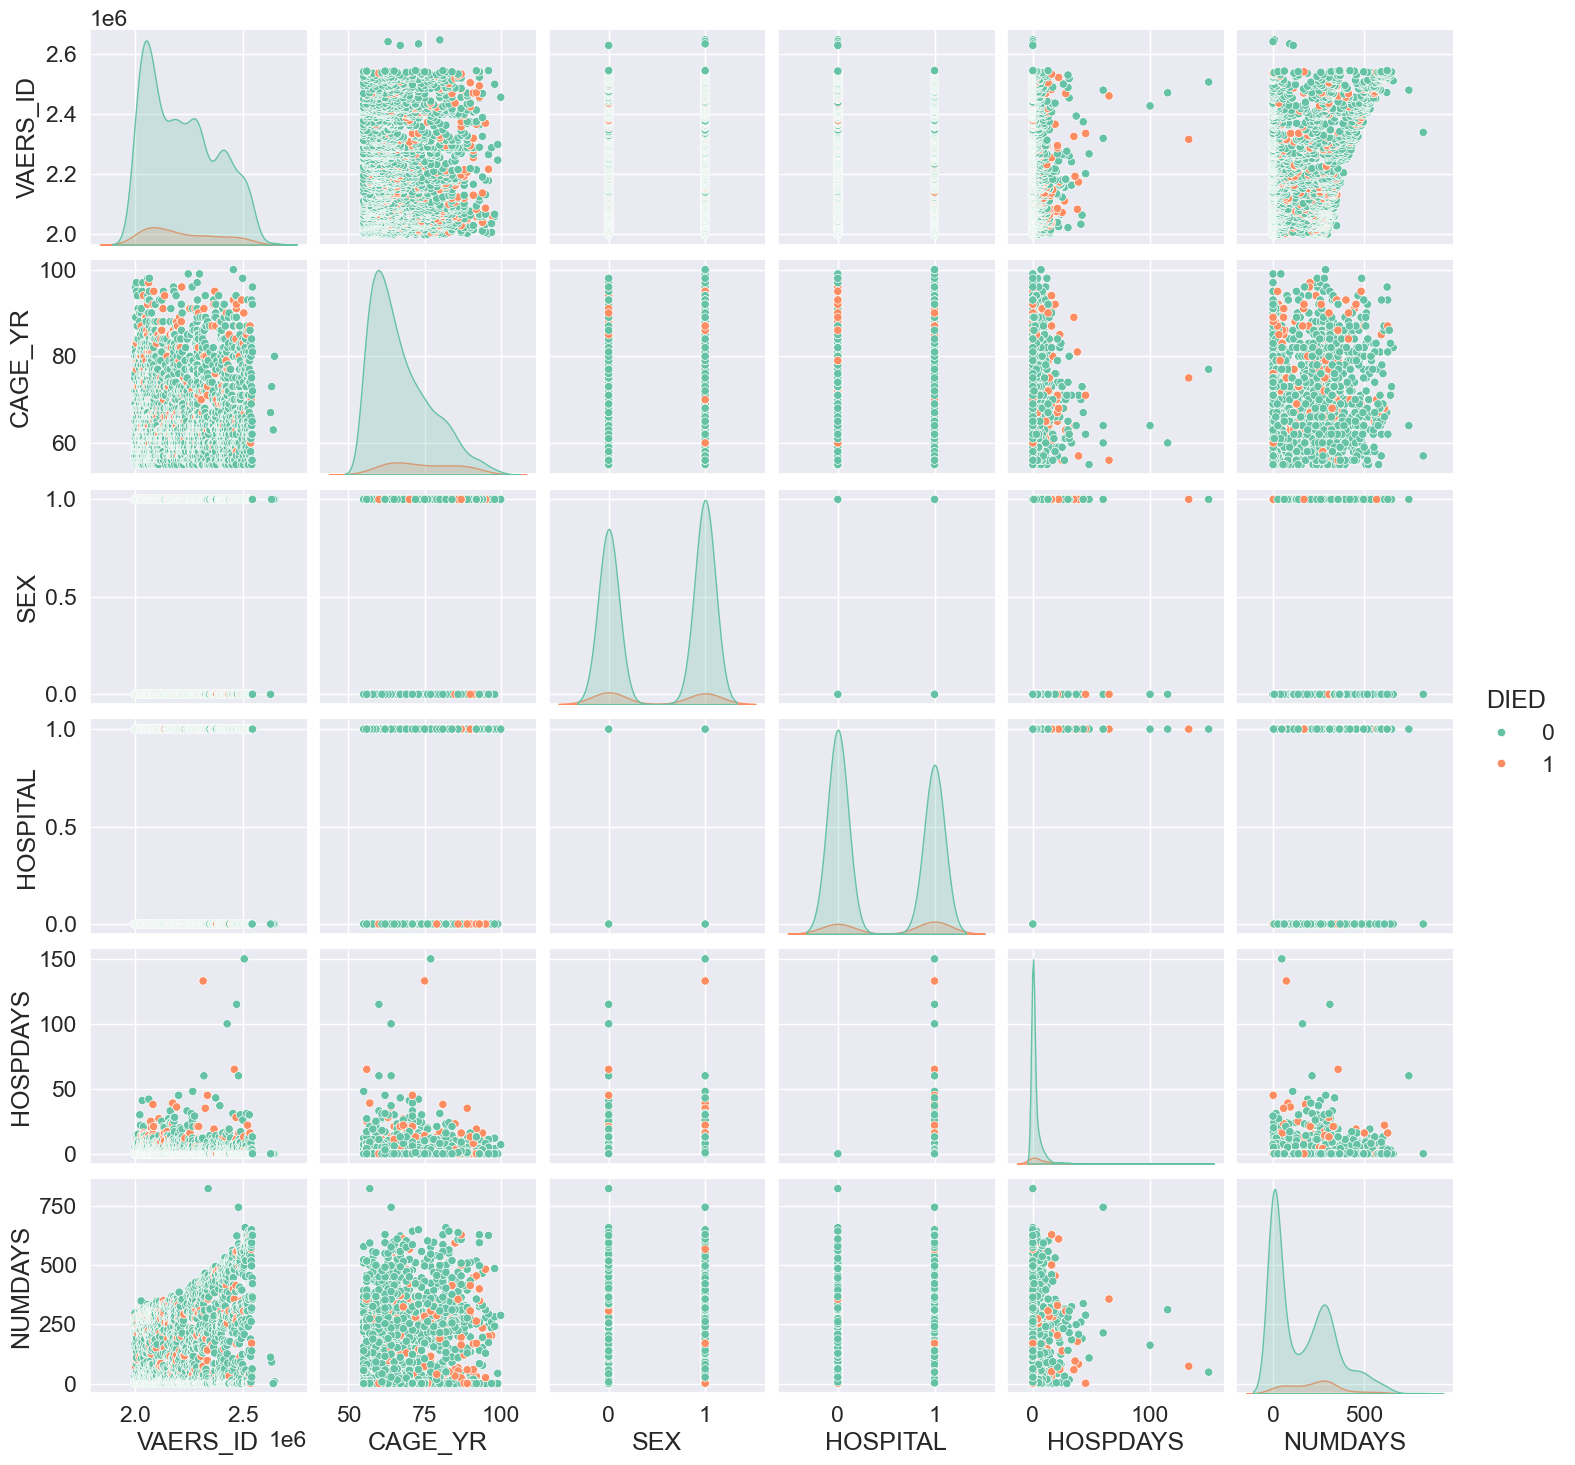

In [15]:
# sns.set(font_scale = 1.5)
# sns.pairplot(data=df, hue='DIED', diag_kind='kde', palette='Set2')

## Model

In [187]:
# with open('Stan/population_0.stan', 'r') as f: 
#    print(f.read())

model_ppc = CmdStanModel(stan_file='../models/model_1_prior.stan')

R = 2000
sim_data = model_ppc.sample(data={'N': 2000},
                        iter_sampling=2000, 
                        iter_warmup=1,
                        refresh=R,
                        fixed_param=True,
                        chains=1)

whot = sim_data.draws_pd()
print(whot[['ages', 'sex', ]])

INFO:cmdstanpy:compiling stan file /root/models/model_1_prior.stan to exe file /root/models/model_1_prior
INFO:cmdstanpy:compiled model executable: /root/models/model_1_prior
INFO:cmdstanpy:CmdStan start processing
chain 1 |██████████| 00:00 Sampling completed


INFO:cmdstanpy:CmdStan done processing.



         ages  sex
0     71.1206  1.0
1     56.5312  1.0
2     71.3464  1.0
3     61.7151  1.0
4     72.1993  0.0
...       ...  ...
1995  75.4136  1.0
1996  81.1341  1.0
1997  60.4844  0.0
1998  65.3138  0.0
1999  60.7293  1.0

[2000 rows x 2 columns]


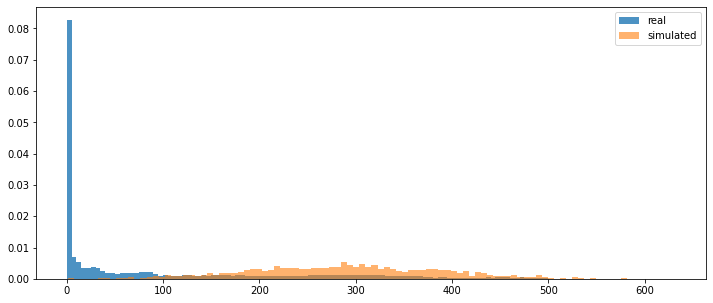

In [188]:
plt.figure(figsize=(12,5))
plt.hist(x=df["NUMDAYS"], bins=100, density=True, alpha=0.8)
plt.hist(x=whot["numdays"],bins=100, density=True, alpha=0.6)
plt.legend(["real", "simulated"])
plt.show()

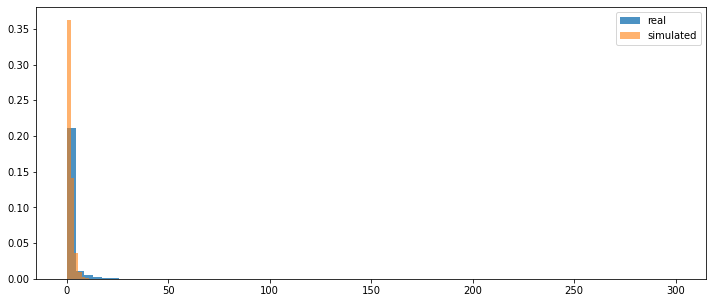

In [189]:
plt.figure(figsize=(12,5))
plt.hist(x=df["HOSPDAYS"], bins=70, density=True, alpha=0.8)
plt.hist(x=whot["hospital_days"],bins=6, density=True, alpha=0.6)
plt.legend(["real", "simulated"])
plt.show()

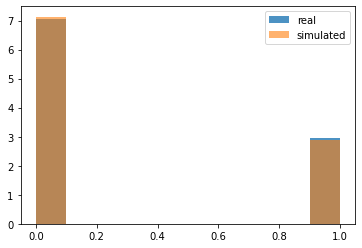

In [190]:
plt.hist(x=df["HOSPITAL"], density=True, alpha=0.8)
plt.hist(x=whot["hospital"], density=True, alpha=0.6)
plt.legend(["real", "simulated"])
plt.show()

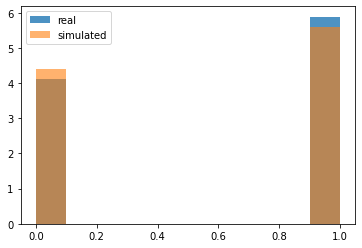

In [191]:
plt.hist(x=df["SEX"], density=True, alpha=0.8)
plt.hist(x=whot["sex"], density=True, alpha=0.6)
plt.legend(["real", "simulated"])
plt.show()

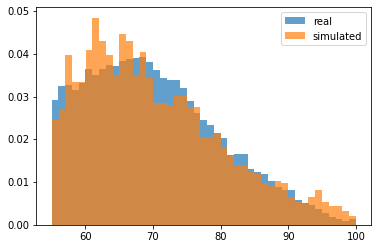

In [192]:
plt.hist(x=df["CAGE_YR"], bins=45, density=True, alpha=0.7)
plt.hist(x=whot["ages"], bins=45, density=True, alpha=0.7)
plt.legend(["real", "simulated"])
plt.show()

In [193]:
df.describe()

,VAERS_ID,CAGE_YR,SEX,DIED,HOSPITAL,HOSPDAYS,NUMDAYS
count,6.221700e+04,62217.000000,62217.000000,62217.000000,62217.000000,62217.000000,62217.000000
mean,2.263114e+06,69.741694,0.589067,0.056544,0.294518,1.374014,99.920890
std,1.524319e+05,9.649824,0.492007,0.230971,0.455829,5.485592,134.514253
min,1.997131e+06,55.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,2.134001e+06,62.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,2.268051e+06,69.000000,1.000000,0.000000,0.000000,0.000000,21.000000
75%,2.387971e+06,76.000000,1.000000,0.000000,1.000000,0.000000,179.000000
max,2.719848e+06,100.000000,1.000000,1.000000,1.000000,300.000000,500.000000


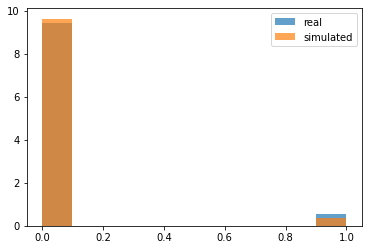

In [198]:
plt.hist(x=df["DIED"], density=True, alpha=0.7)
plt.hist(x=whot["death"], density=True, alpha=0.7)
plt.legend(["real", "simulated"])
plt.show()

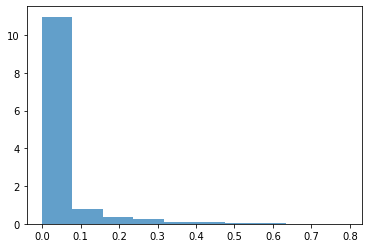

In [199]:
plt.hist(x=whot["p"], density=True, alpha=0.7)
plt.show()